In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from plot_utils import *
import sys
sys.path.append("../")
from difficulty.metrics.metric_utils import combine_metrics_into_df, select_all_replicates, average_columns


N_PERMUTATIONS = 100

def permute_columns(df, num_in_a):
    assert num_in_a < len(df.columns)
    indexes = np.concatenate([np.zeros(num_in_a, dtype=bool), np.ones(len(df.columns) - num_in_a, dtype=bool)])
    np.random.shuffle(indexes)
    split_a = df.iloc[:, indexes]
    split_b = df.iloc[:, np.logical_not(indexes)]
    return split_a, split_b

def one_sided_p_value(test_value, null_values, norm=None):
    test_statistic = np.linalg.norm(test_value, ord=norm)
    null_statistics = [np.linalg.norm(x, ord=norm) for x in null_values]
    null_statistics = np.sort(null_statistics)
    rank = np.searchsorted(null_statistics, test_statistic)
    return 1 - rank / len(null_statistics)

def manhattan_plot(ax, test_stat, null_stats, norm=None, title=""):
    p_values = []
    for idx, row in test_stat.iterrows():
        null_rows = [sample.iloc[idx] for sample in null_stats]
        p_values.append(one_sided_p_value(row, null_rows, norm=norm))
    x = np.arange(len(test_stat))
    p_values = np.array(p_values) + 1e-8
    ax.scatter(x, -1 * np.log(p_values), s=1)
    ax.hlines(-1 * np.log(0.05), x[0], x[-1], linestyles="dotted")
    ax.set_xlabel("example")
    ax.set_ylabel("-log(p)")
    ax.set_title(title)

def permutation_test_model_diff(metrics_dir, use_median, use_rank, norm=None):
    df, metrics, (_, models, replicates) = combine_metrics_into_df(metrics_dir)
    if use_rank:
        df = make_ranks(df)
    else:  # make all features (metrics) the same scale
        df = pd.DataFrame(scale(df.to_numpy(), axis=0), columns=df.columns)
    metrics = order_metrics(metrics)
    models = list(order_models(models).items())
    model_pairs = np.triu_indices(len(models), 1)
    # prepare subplots
    fig = plt.figure(figsize=(6 * len(model_pairs[0]), 4 * 2), constrained_layout=True)
    grid = matplotlib.gridspec.GridSpec(2, len(model_pairs[0]), figure=fig)
    legend_values = []
    # test difference between pairs of models
    for i, (a, b) in enumerate(zip(*model_pairs)):
        model_a, name_a = models[a]
        model_b, name_b = models[b]
        metric_p_values = []
        summary_test_stat = pd.DataFrame()
        summary_null_stats = [pd.DataFrame() for _ in range(N_PERMUTATIONS)]
        for metric in metrics:
            df_a = select_all_replicates(df, model_a, metric)
            df_b = select_all_replicates(df, model_b, metric)
            test_stat = average_columns(df_a) - average_columns(df_b)
            # permutation test: randomly permute which replicates belong to which model
            null_stats = []
            combined_df = df_a.combine_first(df_b)
            for j in range(N_PERMUTATIONS):
                p_a, p_b = permute_columns(combined_df, len(df_a.columns))
                null_stat = average_columns(p_a) - average_columns(p_b)
                summary_null_stats[j][metric] = null_stat
                null_stats.append(null_stat)
            metric_p_values.append(one_sided_p_value(test_stat, null_stats))
            summary_test_stat[metric] = test_stat
        # plot per metric
        ax = fig.add_subplot(grid[0, i])
        plot_heatmap_tiles(ax, np.expand_dims(np.array(metric_p_values), 0), x_labels=metrics, y_labels=["p value"], title=f"{name_a}, {name_b}")
        # plot per example
        ax = fig.add_subplot(grid[1, i])
        manhattan_plot(ax, summary_test_stat, summary_null_stats)
        # for all
        summary_p_value = one_sided_p_value(summary_test_stat, summary_null_stats)
    fig.show()

/tmp/ipykernel_3380/3423522546.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


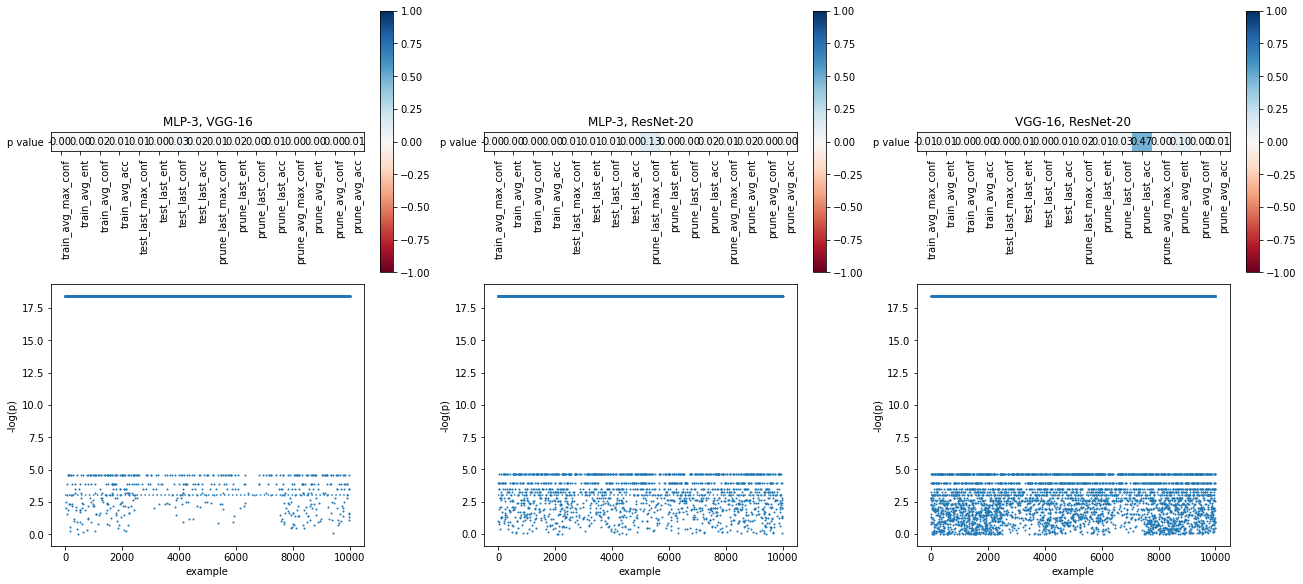

In [20]:
metrics_by_architecture = Path("../outputs")
permutation_test_model_diff(metrics_by_architecture, use_median=False, use_rank=True)

/tmp/ipykernel_3380/3423522546.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


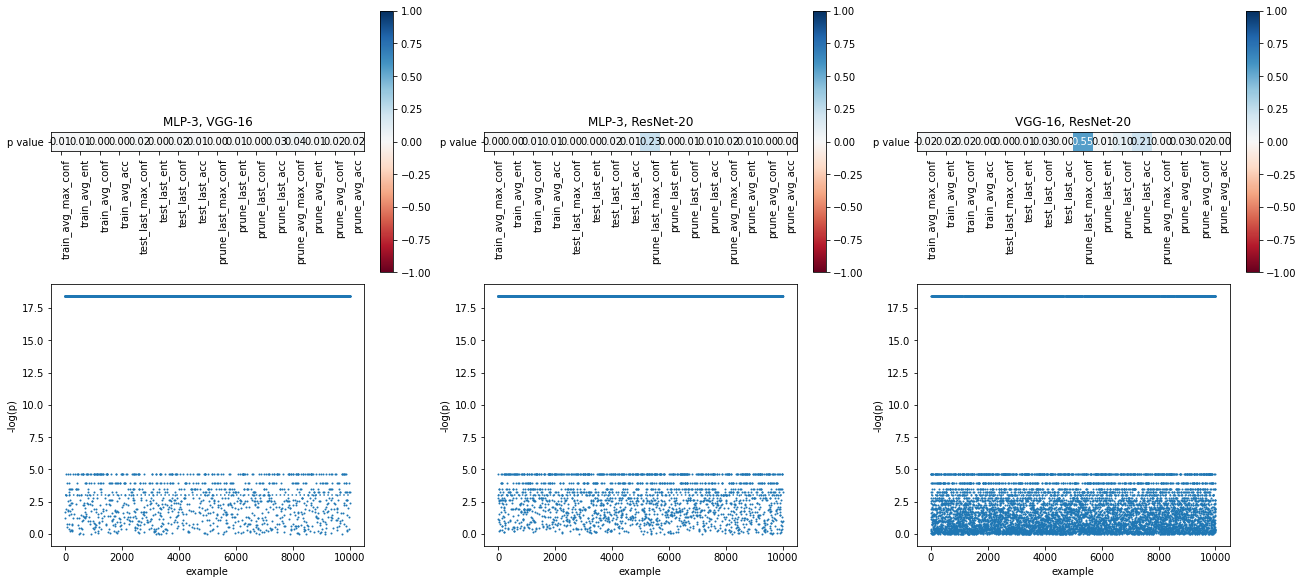

In [21]:
permutation_test_model_diff(metrics_by_architecture, use_median=False, use_rank=False)